In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seawater as sw
import scipy.signal as signal

In [2]:
# import the data
# matrix with all SDS data for each cruise
fileURL = 'https://rest.myria.cs.washington.edu:1776/dataset/user-armbrustlab/program-seaflow/relation-all_sds_v2/data?format=csv'
result = pd.read_csv(fileURL)
print pd.unique(result['Cruise'])

['Thompson_0' 'DEEPDOM' 'CMOP_3' 'KiloMoana_1' 'MBARI_1' 'Tokyo_4'
 'Tokyo_3' 'Tokyo_2' 'Tokyo_1' 'Thompson_12' 'Thompson_1' 'Thompson_10'
 'Thompson_9' 'Thompson_8' 'Thompson_5' 'Thompson_4']


In [3]:
# select data for a particular cruise

cruise = 'KiloMoana_1'
data = result.loc[(result['Cruise']==cruise)]
data = data.sort(['day','file'],ascending=[True,True])

# what variable to use for front detection
value = 'S'

In [4]:
x = (data['LON']).values # longitude
y = (data['LAT']).values # latitude

S = (data['S']).values
T = (data['T']).values

z = np.float32((data[value]).values) # bead attribute

# convert all longitude to longitude east
x[x<0]= 360+x[x<0];
xew = x
xew[xew>180] = xew[xew>180]-360

print(min(x), max(x), min(y), max(y))

distance = sw.dist(y, x)[0]
track = np.cumsum(distance)
track = np.insert(track, 0, 0)

(125.06215900000001, 134.94096399999998, 48.517956833333301, 49.3239515)


In [5]:
# First, design the Buterworth filter
N  = 2    # Filter order
Wn = 0.5 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
 
# Second, apply the filter
Tf = signal.filtfilt(B,A, T)
Sf = signal.filtfilt(B,A, S)

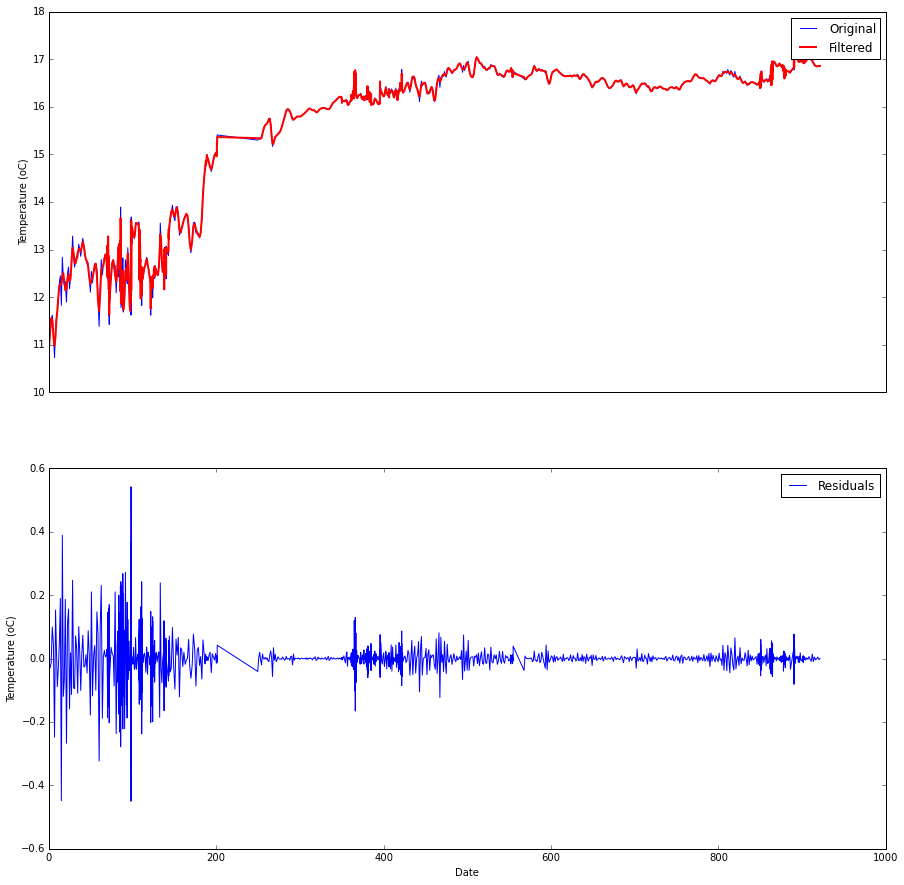

In [6]:
# plot filtered T and S
fig = plt.figure(1, figsize=(15,15))

ax1 = fig.add_subplot(211)
plt.plot(track,T, 'b-')
plt.plot(track,Tf, 'r-',linewidth=2)
plt.ylabel("Temperature (oC)")
plt.legend(['Original','Filtered'])
ax1.axes.get_xaxis().set_visible(False)
 
ax1 = fig.add_subplot(212)
plt.plot(track,T-Tf, 'b-')
plt.ylabel("Temperature (oC)")
plt.xlabel("Date")
plt.legend(['Residuals'])


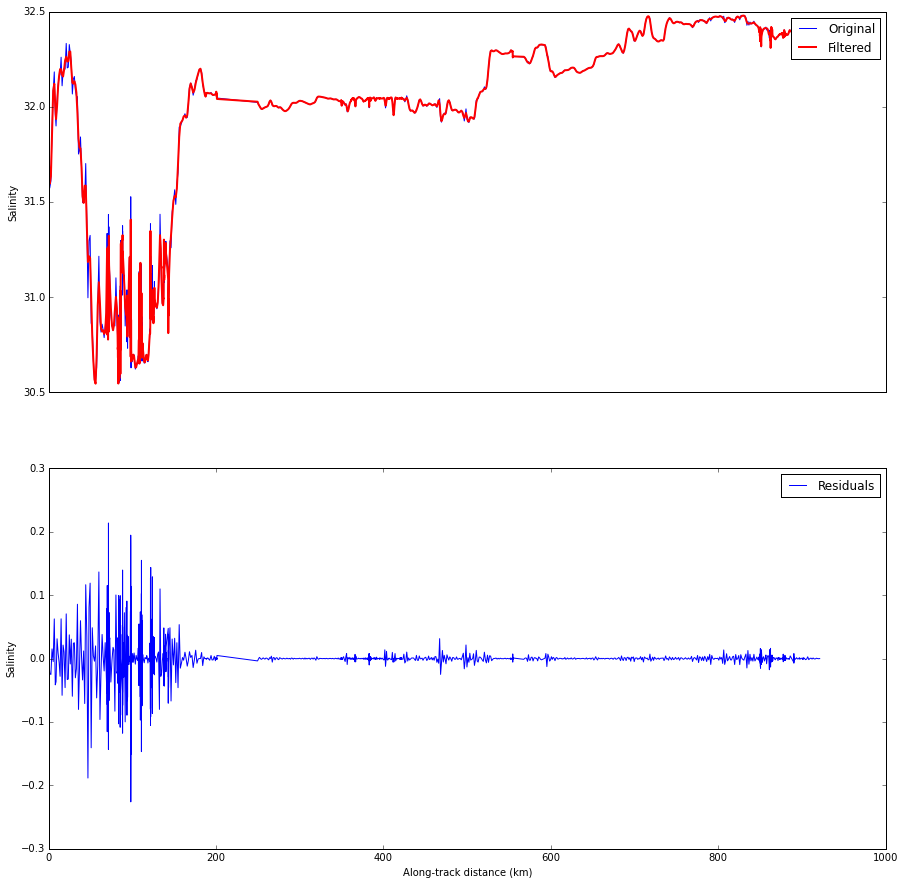

In [7]:
fig2 = plt.figure(2, figsize=(15,15))

ax1 = fig2.add_subplot(211)
plt.plot(track,S, 'b-')
plt.plot(track,Sf, 'r-',linewidth=2)
plt.ylabel("Salinity")
plt.legend(['Original','Filtered'])
ax1.axes.get_xaxis().set_visible(False)
 
ax1 = fig2.add_subplot(212)
plt.plot(track,S-Sf, 'b-')
plt.ylabel("Salinity")
plt.xlabel("Along-track distance (km)")
plt.legend(['Residuals'])

In [8]:
print(len(Tf), len(Sf), len(track))

(3315, 3315, 3315)


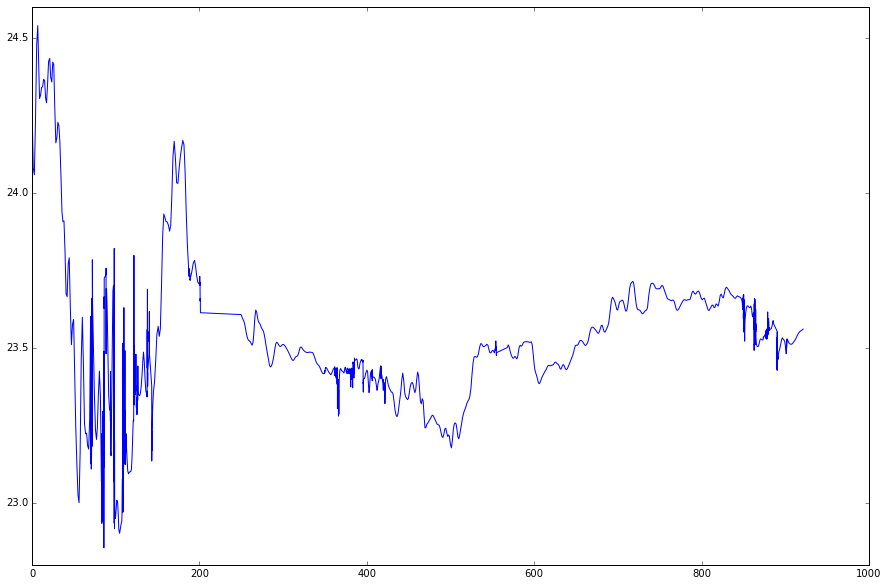

In [9]:
# calculate density from filtered data
# calculate density and gradient
D = sw.dens(Sf,Tf,0)

fig3 = plt.figure(2, figsize=(15,10))
plt.plot(track, D -1000)
plt.show()

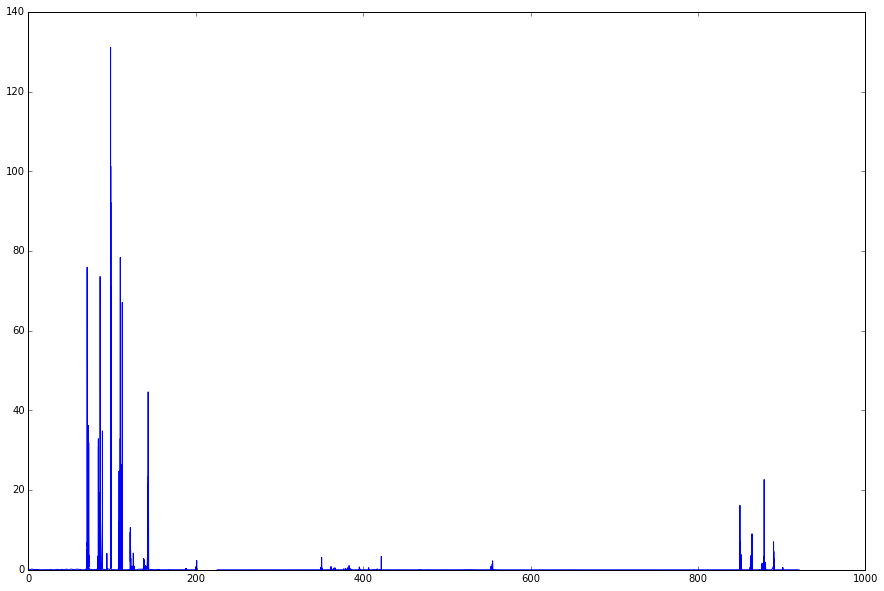

In [10]:
# gradients
dD = (D[1:len(D)]-D[:len(D)-1])/distance
dS = (Sf[1:len(Sf)]-Sf[:len(Sf)-1])/distance
dT = (Tf[1:len(Tf)]-Tf[:len(Tf)-1])/distance

# calculate point along track where gradient is calculated
dD_track = track[0:len(track)-1]+distance/2

fig3 = plt.figure(2, figsize=(15,10))
plt.plot(dD_track, abs(dS))
plt.show()